# ölksdjaföalksdjf

## TOC
- lkajsdfölakd
- asdflkasdjföl

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm


# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


In [2]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(202878, 470)


In [3]:
print(dates)

0         2000-01-01 00:00:00
1         2000-01-01 01:00:00
2         2000-01-01 02:00:00
3         2000-01-01 03:00:00
4         2000-01-01 04:00:00
                 ...         
202873    2022-12-30 20:00:00
202874    2022-12-30 21:00:00
202875    2022-12-30 22:00:00
202876    2022-12-30 23:00:00
202877    2022-12-31 00:00:00
Name: Date, Length: 202878, dtype: object


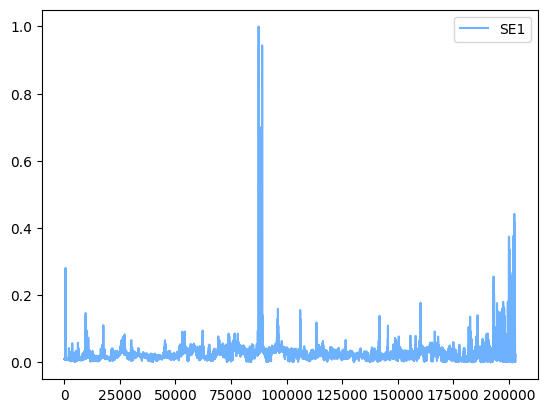

In [4]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [5]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


In [6]:
# Define the sequence length for the LSTM model
sequence_length = 10

def create_sequences(df, sequence_length):
    X = []
    y = []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length, 1:].values)
        y.append(df.iloc[i+sequence_length, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_df, sequence_length)
X_val, y_val = create_sequences(val_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(172438, 10, 469)
(20277, 10, 469)
(10133, 10, 469)


In [7]:
batch_size = 128
print(y_val.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train, :, :]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val, :, :]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test, :, :]
y_test = y_test[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(20277,)


(172416,)


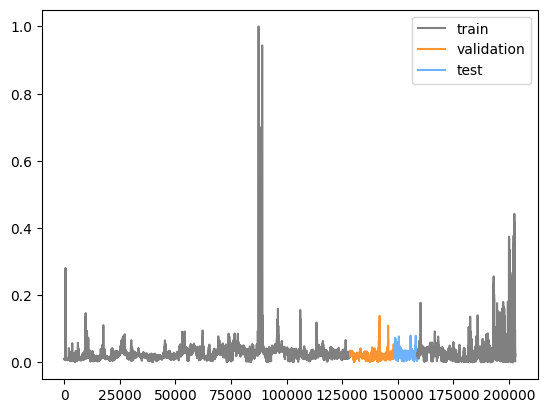

In [8]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [9]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, sequence_length, n_features), return_sequences=True, stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Normalization(),
    tf.keras.layers.LSTM(32, batch_input_shape=(batch_size, sequence_length, n_features), stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [10]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color='grey')
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color='#6db1ff')
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [11]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping, PlotLearning()])
  return history

# Baseline

## Train Baseline

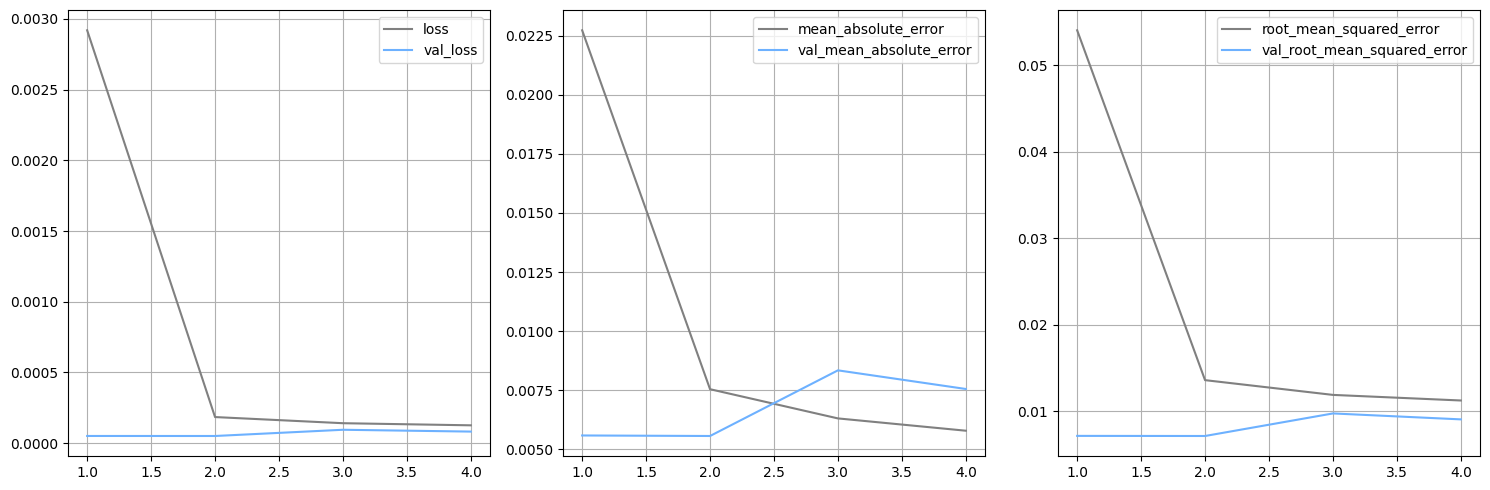

1347/1347 [==============================] - 30s 23ms/step - loss: 1.2649e-04 - mean_absolute_error: 0.0058 - root_mean_squared_error: 0.0112 - val_loss: 8.2162e-05 - val_mean_absolute_error: 0.0076 - val_root_mean_squared_error: 0.0091


In [12]:

history = compile_and_fit(model, X_train, y_train)


## Baseline result/residuals

In [13]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 2s 11ms/step


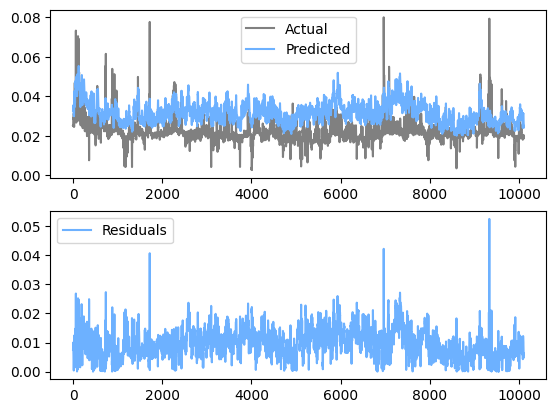

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(y_test, label='Actual', color='grey')
ax1.plot(result, label='Predicted', color='#6db1ff')
residuals = abs(np.subtract(np.array(result[:,0]), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color='#6db1ff')
ax2.legend()

## Baseline feature importance

In [15]:
COLS = list(df.columns[1:])
n_cols = len(COLS)
# n_cols = 5
# results = []
print('Computing LSTM feature importance...')

# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = model.predict(X_val, verbose=0, batch_size=batch_size).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-y_val ))
# results.append({'feature':'BASELINE','mae':baseline_mae})           
fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
fi_df.to_csv('feature_importance.csv', index=False, header=False)
for k in range(n_cols):
    # SHUFFLE FEATURE K
    save_col = X_val[:,:,k].copy()
    X_val[:,:,k] = np.zeros((X_val.shape[0],X_val.shape[1]))
            
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model.predict(X_val, verbose=0, batch_size=batch_size).squeeze() 
    mae = np.mean(np.abs( oof_preds-y_val ))
    # results.append({'feature':COLS[k],'mae':mae})
    fi_df = pd.DataFrame([COLS[k], mae]).T
    fi_df.to_csv('feature_importance.csv', mode='a', index=False, header=False)
    X_val[:,:,k] = save_col


Computing LSTM feature importance...


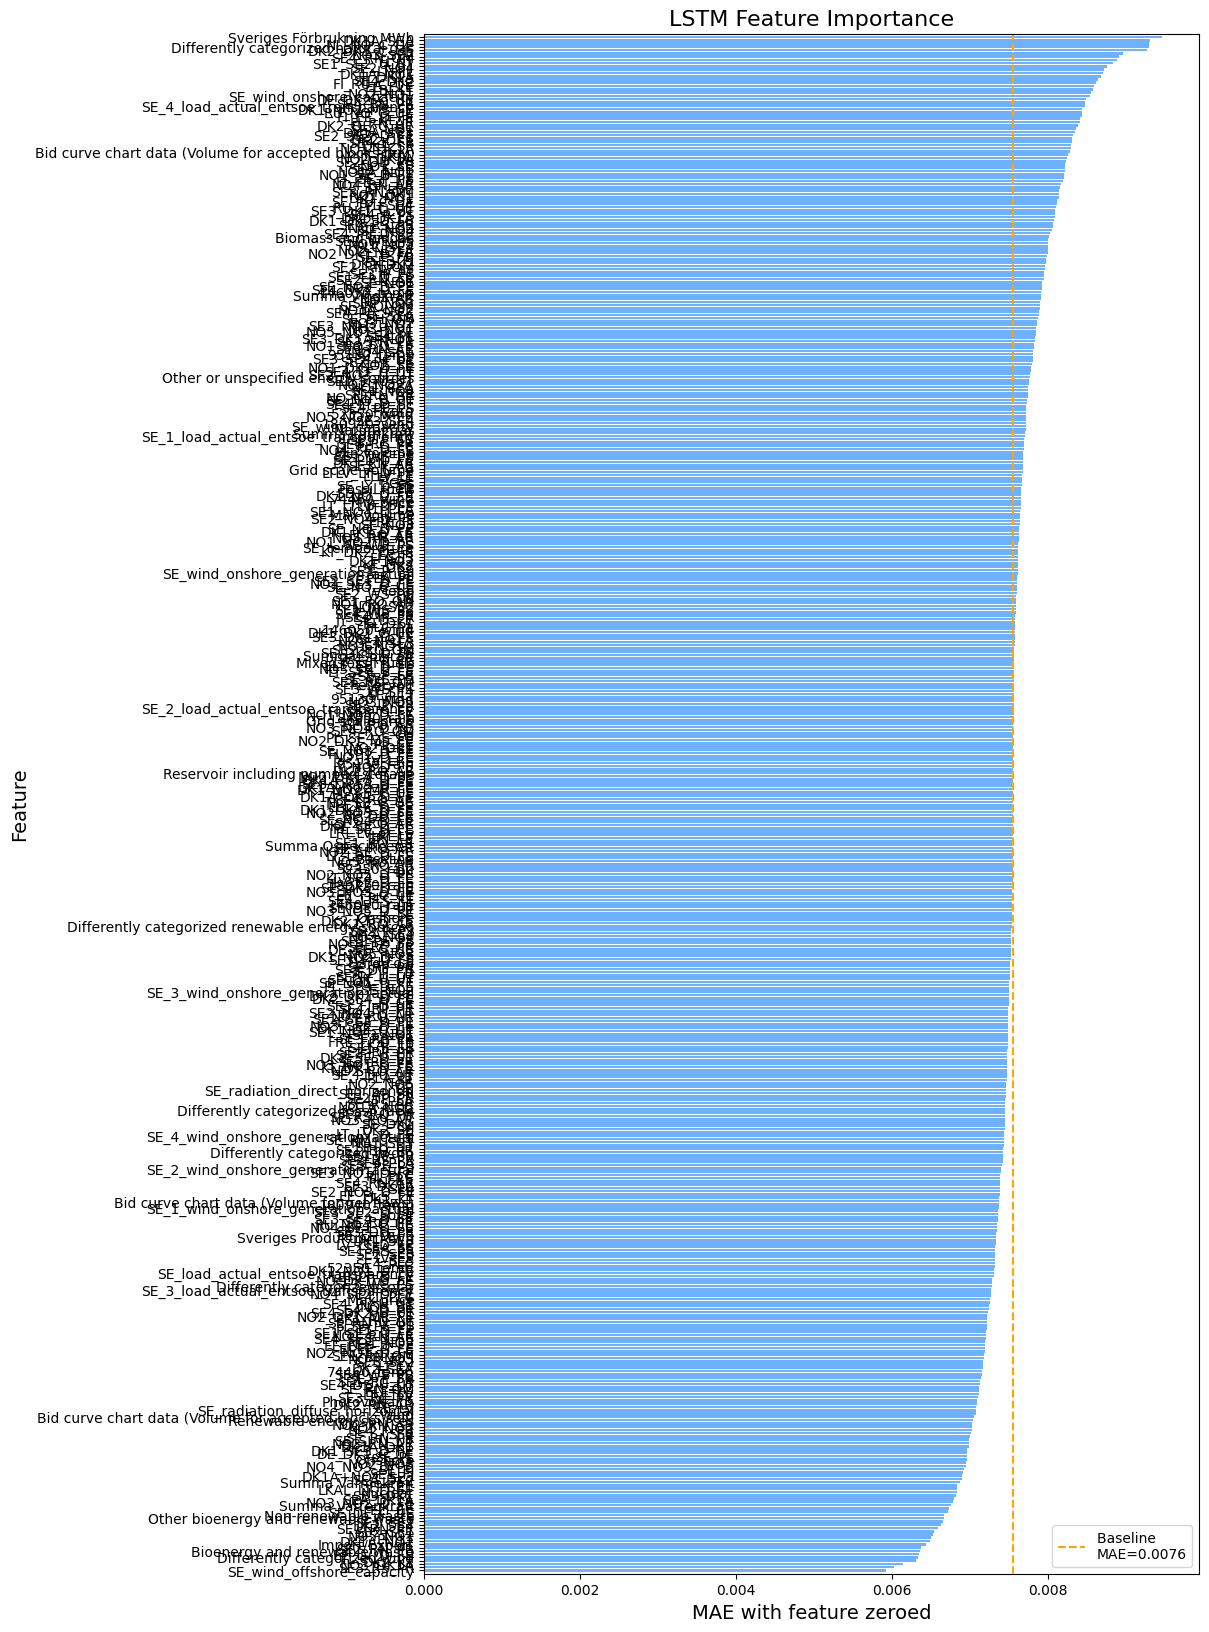

In [16]:

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df2 = pd.read_csv('feature_importance.csv', header=None, names=['feature','mae'])
df2 = df2.sort_values('mae')

plt.figure(figsize=(10,20))
plt.barh(np.arange(n_cols+1),df2.mae, color='#6db1ff')
plt.yticks(np.arange(n_cols+1),df2.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,n_cols+1))

plt.plot([baseline_mae,baseline_mae],[-1,n_cols+1], '--', color='orange',
            label=f'Baseline \nMAE={baseline_mae:.4f}')

plt.xlabel(f'MAE with feature zeroed',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

# Data Analysis functions

Compute the average number of features that has low data uniqueness

In [234]:
def unique_average(data, n=25000):
# antal unika värden i snitt per feature
    list = []
    for i in range(data.shape[1]):
        list.append(data.iloc[:,i].nunique())
    list = pd.DataFrame(list)
    print('Share of columns that has less than n/25000 unique values')
    print(list[list < n].count()/data.shape[1])

Create a boxplot

In [235]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 10))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    # rectangular box plot
    bplot1 = ax1.boxplot(data,
                        vert=False,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=columns)  # will be used to label x-ticks

    for patch in bplot1['boxes']:
        patch.set_facecolor('#6db1ff')
    plt.show()

In [ ]:
def run_analysis_suite(data, columns, n=25000):
    unique_average(data, n)
    boxplot(data, columns)

# Iteration 1

## Data analysis

### Feature Importance cutoff

In [1]:
# DISPLAY LSTM FEATURE IMPORTANCE
df2 = pd.read_csv('feature_importance.csv', header=None, names=['feature','mae'])
df2 = df2.sort_values('mae')

cutoff = np.std(df2).mae
b_set_columns = df2[df2['mae'] < baseline_mae - cutoff].feature

plt.figure(figsize=(10,20))
plt.barh(np.arange(n_cols+1),df2.mae, color='#6db1ff')
plt.yticks(np.arange(n_cols+1),df2.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,n_cols+1))

plt.plot([baseline_mae,baseline_mae],[-1,n_cols+1], '--', color='orange',
            label=f'Baseline \nMAE={baseline_mae:.4f}')
plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color='red',
            label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

plt.xlabel(f'MAE with feature zeroed',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

NameError: name 'pd' is not defined

#### B set

0    0.816327
dtype: float64


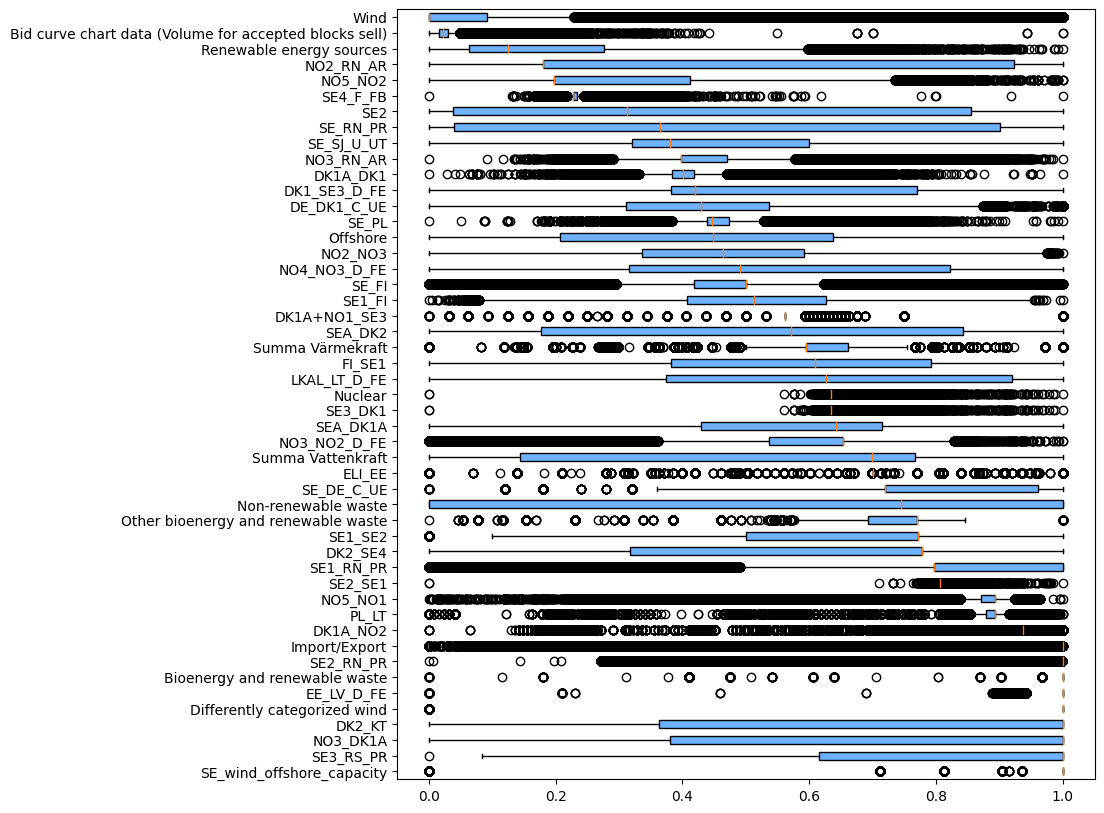

In [236]:
b_set = df[b_set_columns]
run_analysis_suite(b_set, b_set_columns)

#### A set

In [ ]:
a_set = df[~b_set_columns]
a_set_columns = a_set.columns
run_analysis_suite(a_set, a_set_columns)

### Time slice analysis